<a href="https://colab.research.google.com/github/mshakya36/Customer-Segmentation-using-Clustering/blob/main/Wallet_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

In [2]:
# Load CSV
sheet_id = '1EM7bUpKaU2ueJad7w1LII0d6JxDEHWh-hAmBcZLFp_M'
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid=0"
df = pd.read_csv(url)
df.head()

,user_id,txn_amount,wallet_balance,subwallet_balance,age_group,city,txn_type,payment_mode,transaction_flag,gender,device_type,txn_date,is_successful
0,U00000,663.98,8782.19,812.05,18-25,Chennai,one-time,Card,P2B,Other,iOS,2023-11-12,1
1,U00001,272.60,2165.81,922.92,36-45,Bangalore,auto-add,Netbanking,P2M,Other,iOS,2023-04-18,1
2,U00002,498.47,5010.70,947.04,26-35,Kolkata,auto-add,Card,P2P,Other,Android,2023-04-23,1
3,U00003,168.46,3542.62,683.20,18-25,Bangalore,one-time,Wallet,P2P,Male,Web,2023-06-24,1
4,U00004,415.72,4058.60,211.37,46-60,Delhi,one-time,Wallet,P2B,Other,Android,2023-01-14,1


In [3]:
# Step 1: Feature selection
features = ['txn_amount', 'wallet_balance', 'subwallet_balance',
            'age_group', 'city', 'txn_type', 'payment_mode',
            'transaction_flag', 'gender', 'device_type']

X = df[features]

In [4]:
# Step 2: Preprocessing
num_cols = ['txn_amount', 'wallet_balance', 'subwallet_balance']
cat_cols = ['age_group', 'city', 'txn_type', 'payment_mode',
            'transaction_flag', 'gender', 'device_type']

In [5]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first'), cat_cols)
])

In [6]:
X_processed = preprocessor.fit_transform(X)

In [7]:
# Get column names
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
all_features = list(num_cols) + list(cat_features)

# Convert to DataFrame
X_df = pd.DataFrame(X_processed.toarray() if hasattr(X_processed, 'toarray') else X_processed, columns=all_features)

In [8]:
# Step 3: Elbow method to get optimal K and Silhouette scores
inertia = []
sil_scores = []
K = range(2, 11)

for k in K:
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = model.fit_predict(X_df)
    inertia.append(model.inertia_)
    sil_scores.append(silhouette_score(X_df, labels))

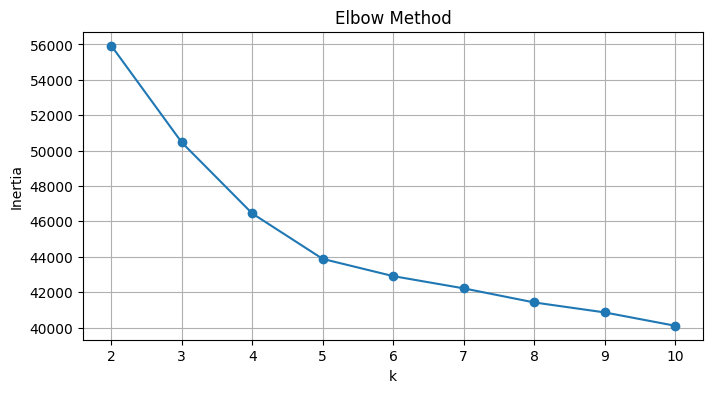

In [9]:
# Plot Elbow
plt.figure(figsize=(8, 4))
plt.plot(K, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [10]:
sil_scores.index(max(sil_scores))

1

In [11]:
# Print best silhouette score
optimal_k = sil_scores.index(max(sil_scores)) + 2
print(f"Optimal k based on silhouette score: {optimal_k}")

Optimal k based on silhouette score: 3


In [12]:
# Step 4: Final KMeans
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_df)

In [13]:
# Step 5: Cluster Summary
summary = df.groupby('cluster').agg({
    'txn_amount': 'mean',
    'wallet_balance': 'mean',
    'subwallet_balance': 'mean',
    'age_group': lambda x: x.mode()[0],
    'city': lambda x: x.mode()[0],
    'txn_type': lambda x: x.mode()[0],
    'payment_mode': lambda x: x.mode()[0],
    'transaction_flag': lambda x: x.mode()[0],
    'gender': lambda x: x.mode()[0],
    'device_type': lambda x: x.mode()[0],
    'is_successful': 'mean'
}).round(2)

In [14]:
print(summary)

         txn_amount  wallet_balance  subwallet_balance age_group     city  \
cluster                                                                     
0            851.25         4793.16             516.26     36-45  Chennai   
1            189.35         5102.75             745.92     46-60    Delhi   
2            203.92         5300.21             239.34     26-35  Kolkata   

         txn_type payment_mode transaction_flag gender device_type  \
cluster                                                              
0        one-time         Card              P2B   Male     Android   
1        auto-add          UPI              P2B   Male     Android   
2        auto-add   Netbanking              P2P  Other     Android   

         is_successful  
cluster                 
0                 0.95  
1                 0.95  
2                 0.95  


In [15]:
from sklearn.decomposition import PCA

In [28]:
# Fit KMeans models
kmeans_3 = KMeans(n_clusters=3, random_state=42, n_init=10).fit(X_df)
kmeans_4 = KMeans(n_clusters=4, random_state=42, n_init=10).fit(X_df)
kmeans_5 = KMeans(n_clusters=5, random_state=42, n_init=10).fit(X_df)

In [17]:
# Reduce dimensions with PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_df)

In [29]:
# Prepare DataFrame
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Cluster_k3'] = kmeans_3.labels_
pca_df['Cluster_k4'] = kmeans_4.labels_
pca_df['Cluster_k5'] = kmeans_5.labels_

In [20]:
import seaborn as sns

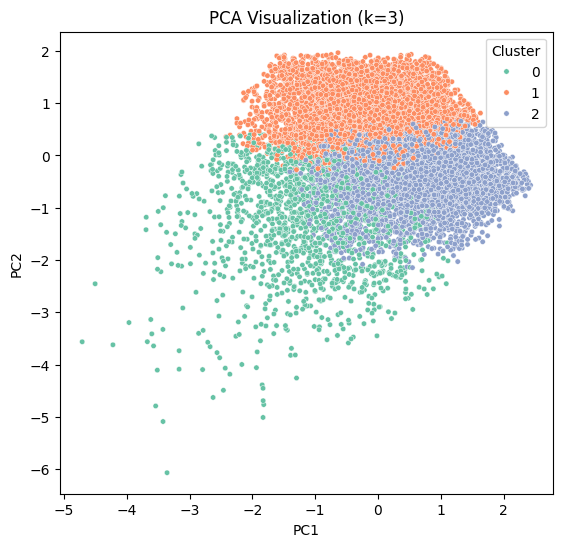

In [21]:
# Plot k=3
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster_k3', palette='Set2', s=15)
plt.title('PCA Visualization (k=3)')
plt.legend(title='Cluster', loc='upper right')
#some overlap between green and blue clusters, but it looks good with few exceptions.

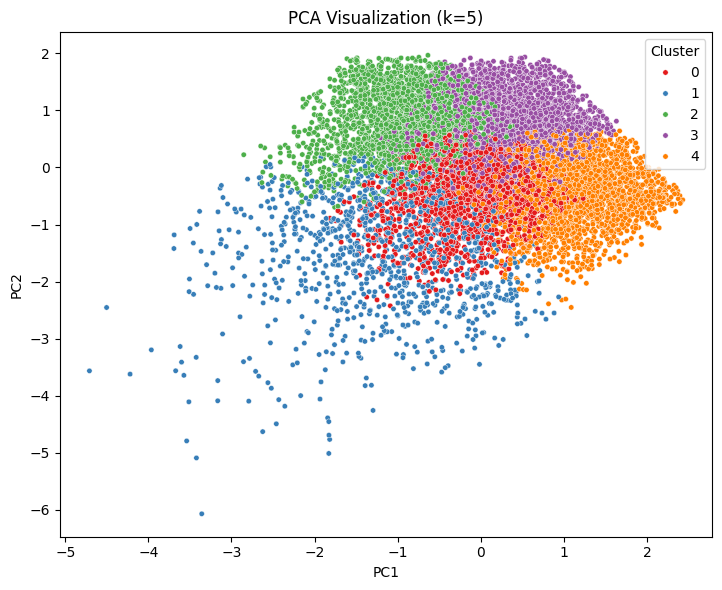

In [25]:
# Plot k=5
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 2)
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster_k5', palette='Set1', s=15)
plt.title('PCA Visualization (k=5)')
plt.legend(title='Cluster', loc='upper right')

plt.tight_layout()
plt.show()
# There is some overlap of red cluster with other clusters.

In [23]:
from sklearn.metrics import silhouette_score

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_df)
    print(f"k={k}, silhouette score = {silhouette_score(X_df, labels):.3f}")

k=2, silhouette score = 0.113
k=3, silhouette score = 0.117
k=4, silhouette score = 0.107
k=5, silhouette score = 0.097
k=6, silhouette score = 0.092
k=7, silhouette score = 0.080
k=8, silhouette score = 0.080
k=9, silhouette score = 0.065
k=10, silhouette score = 0.072


In [27]:
from sklearn.metrics import davies_bouldin_score

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_df)
    print(f"k={k}, DBI = {davies_bouldin_score(X_df, labels):.3f}")


k=2, DBI = 2.679
k=3, DBI = 2.298
k=4, DBI = 2.096
k=5, DBI = 2.189
k=6, DBI = 2.349
k=7, DBI = 2.653
k=8, DBI = 2.587
k=9, DBI = 2.870
k=10, DBI = 2.685


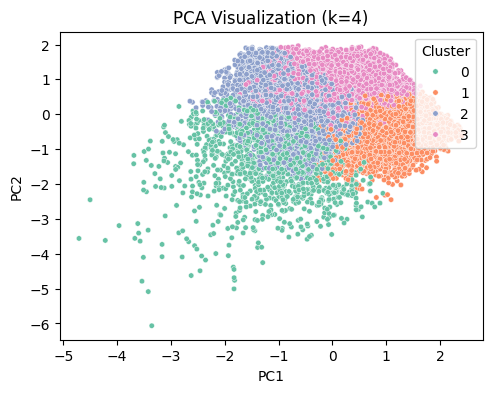

In [39]:
# Plot k=4
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster_k4', palette='Set2', s=15)
plt.title('PCA Visualization (k=4)')
plt.legend(title='Cluster', loc='upper right')
# Blue cluster overlapping

k = 3 looks good. We're going with it.

In [38]:
print(summary[['txn_amount','wallet_balance','subwallet_balance','age_group','txn_type','payment_mode','transaction_flag']])

         txn_amount  wallet_balance  subwallet_balance age_group  txn_type  \
cluster                                                                      
0            851.25         4793.16             516.26     36-45  one-time   
1            189.35         5102.75             745.92     46-60  auto-add   
2            203.92         5300.21             239.34     26-35  auto-add   

        payment_mode transaction_flag  
cluster                                
0               Card              P2B  
1                UPI              P2B  
2         Netbanking              P2P  
